Explore datasets

In [70]:
# Book Data
import ftplib

def list_ftp_files(host, directory):
    with ftplib.FTP(host) as ftp:
        ftp.login()  # login as anonymous user
        ftp.cwd(directory)  # change to the target directory
        files = ftp.nlst()  # list files and directories
        return files

# FTP server details
host = 'ftp.ibiblio.org'
directory = '/pub/docs/books/gutenberg/'

files = list_ftp_files(host, directory)
# print(type(files))


In [ ]:
def strip_punctuation(word):
    punctuation_chars = ["'", '"', ",", ".", "!", ":", ";", '#', '@', '(', ')', "'"]
    for i in punctuation_chars:
        word = word.replace(i, "")
    return word


def strip_stopwords(bk_word_lst):
    with open('stop_words.txt', 'r') as sw:
        stopwords = [w.strip() for w in sw]
        for a in stopwords:
            for w in bk_word_lst:
                if w == a:
                    bk_word_lst.remove(w)
        return bk_word_lst


def strip_digits(word_list):
    for ele in word_list:
        if ele.isdigit():
            word_list.remove(ele)
    return word_list


def strip_other(word_list):
    for e in word_list:
        if '{' in e or ']' in e:
            word_list.remove(e)
    return word_list

In [33]:
import re

# Read the entire book into a single string
with open('/home/aletia/wsl_code/gatech/cse-6040/data-mining-compression/data/roots.txt', 'r', encoding='utf-8') as file:
    book_text = file.read()

ack_end_pattern = r"ACKNOWLEDGMENTS(.*)"
ack_match = re.search(ack_end_pattern, book_text, re.DOTALL)

if ack_match:
    post_ack_text = ack_match.group(1)
    

# Regex to find the chapters in the text after ACKNOWLEDGMENTS
chapter_pattern = r"(CHAPTER \d+.*?)(?=CHAPTER \d+|$)"
chapters = re.findall(chapter_pattern, post_ack_text, re.DOTALL)

# there are 120 chapters: check
print(len(chapters))


120


In [44]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from scipy.linalg import svd

# chapter 1
text = chapters[0]


# Manual sentence tokenization
def simple_sentence_tokenizer(text):
    # Splitting by period followed by a space or end of string
    sentences = [sentence.strip() for sentence in text.replace('?', '.').replace('!', '.').split('.') if sentence]
    return sentences

sentences = simple_sentence_tokenizer(text)

# Convert text to a TF-IDF matrix
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(sentences)

# Compute SVD
n_components = 2  # Number of singular values to keep
svd = TruncatedSVD(n_components=n_components)
X_reduced = svd.fit_transform(X)
X_compressed = np.dot(X_reduced, svd.components_)

# Decompress
X_decompressed = svd.inverse_transform(X_reduced)

# Compute error
original_matrix = X.toarray()
decompressed_matrix = X_decompressed
error = np.linalg.norm(original_matrix - decompressed_matrix)

print("Original Matrix Shape:", original_matrix.shape)
print("Compressed Matrix Shape:", X_compressed.shape)
print("Decompressed Matrix Shape:", decompressed_matrix.shape)
print("Compression Error:", error)



Original Matrix Shape: (41, 351)
Compressed Matrix Shape: (41, 351)
Decompressed Matrix Shape: (41, 351)
Compression Error: 6.0194787450341485


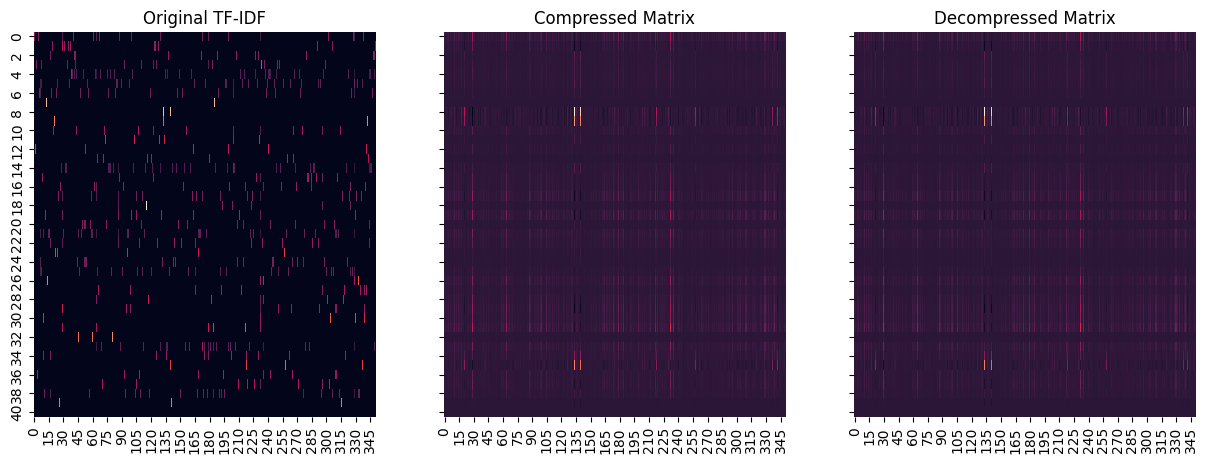

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming original_matrix, X_compressed, decompressed_matrix are available

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
sns.heatmap(original_matrix, ax=axs[0], cbar=False)
axs[0].set_title('Original TF-IDF')
sns.heatmap(X_compressed, ax=axs[1], cbar=False)
axs[1].set_title('Compressed Matrix')
sns.heatmap(decompressed_matrix, ax=axs[2], cbar=False)
axs[2].set_title('Decompressed Matrix')
plt.show()


In [46]:
original_size = original_matrix.shape[0] * original_matrix.shape[1]
compressed_size = X_reduced.shape[0] * X_reduced.shape[1] + X_reduced.shape[0] + svd.components_.shape[0]
compression_ratio = original_size / compressed_size
print(f"Compression Ratio: {compression_ratio:.2f}")

Compression Ratio: 115.13


In [47]:
import time

start_time = time.time()
# Assume svd.fit_transform and svd.inverse_transform are the functions used
X_reduced = svd.fit_transform(X)
X_decompressed = svd.inverse_transform(X_reduced)
elapsed_time = time.time() - start_time
print(f"Elapsed time for compression and decompression: {elapsed_time:.4f} seconds")

Elapsed time for compression and decompression: 0.0094 seconds


In [48]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(original_matrix, decompressed_matrix)
average_similarity = np.mean(similarity)
print(f"Average cosine similarity between original and decompressed: {average_similarity:.4f}")

Average cosine similarity between original and decompressed: 0.1545
